In this notebook I'll look at the average position of players in order to extract the formation of a team.

In [4]:
import sys
sys.path.insert(0,'..')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import football_modelling.metrica.io as mio
import football_modelling.metrica.viz as mviz
from football_modelling.data import load_metrica_dir
import numpy as np
import pandas as pd

# set up initial path to data
DATADIR = load_metrica_dir()
game_id = 2  # let's look at sample match 2


In [6]:
events = mio.read_event_data(DATADIR, game_id)
tracking_home = mio.tracking_data(DATADIR, game_id, "Home")
tracking_away = mio.tracking_data(DATADIR, game_id, "Away")
# Convert positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)
events = mio.to_metric_coordinates(events)
# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home, tracking_away, events = mio.to_single_playing_direction(
    tracking_home, tracking_away, events
)


Reading team: home
Reading team: away


(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

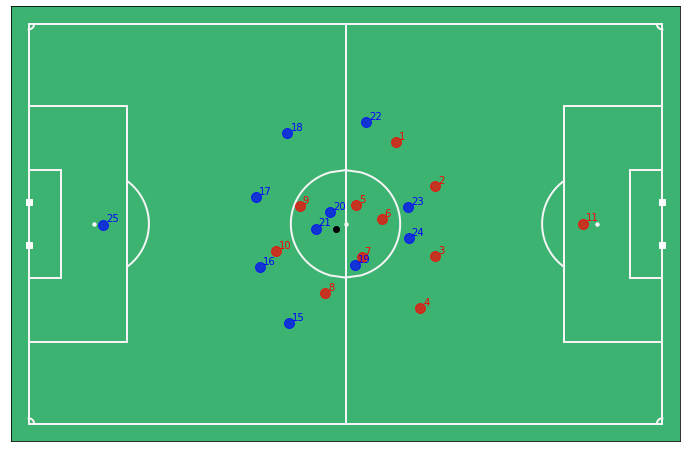

In [8]:
# use only players that were on the pitch at the start of the game
# use pandas.describe to easily get the mean positions
mviz.plot_frame(
    tracking_home.describe()
    .loc["mean"]
    .drop(
        [x for x in tracking_home.columns for y in ["_12_", "_13_", "_14_"] if y in x]
    ),
    tracking_away.describe()
    .loc["mean"]
    .drop(
        [x for x in tracking_away.columns for y in ["_26_", "_27_", "_28_"] if y in x]
    ),
    include_player_velocities=False,
    annotate=True,
)


This shows us that the home team (red) plays a 4-3-3 with a single pivot. The away team can be interpreted as the same formation, with the right winger (24) tucked in. It is also possible that 20 and 21 are a double pivot, 19 is the winger (hanging low) and either 24 or 23 plays as a 10 with overlapping runs over the striker.

It would be interesting to split the formations by whether a team is in possession. Sometimes teams use different formations when defending and attacking.

To find this out, I can use the 'BALL LOST' event type in the events dataframe (BALL LOST seems to be slightly more complete than INTERCEPTION). 
- Match the rows to the event dataframe by time
- Reverse the value of the TEAM column (if away loses the ball, home is in possession and vice versa)
- Also add kick-offs as a special case
- Fill all empty rows with the previous non-empty value

In [10]:
# create event frame with possession info
possession_change_frame_1 = events[events["Type"] == "BALL LOST"]
possession_change_frame_1["team_in_possession"] = np.where(
    possession_change_frame_1["Team"] == "Away", "Home", "Away"
)
possession_change_frame_2 = events[events["Subtype"] == "KICK OFF"]
possession_change_frame_2["team_in_possession"] = possession_change_frame_2["Team"]
possession_change_frame = pd.concat(
    [possession_change_frame_1, possession_change_frame_2]
)[["End Time [s]", "team_in_possession"]]
possession_change_frame

# match to home event frame
tracking_home_augmented = tracking_home.merge(
    possession_change_frame, how="left", left_on="Time [s]", right_on="End Time [s]"
)
# match to away frame
tracking_away_augmented = tracking_away.merge(
    possession_change_frame, how="left", left_on="Time [s]", right_on="End Time [s]"
)
# forward fill null values
tracking_home_augmented["team_in_possession"] = tracking_home_augmented[
    "team_in_possession"
].fillna(method="ffill")
tracking_away_augmented["team_in_possession"] = tracking_away_augmented[
    "team_in_possession"
].fillna(method="ffill")
tracking_away_augmented

home_in_possession = tracking_home_augmented[
    tracking_home_augmented["team_in_possession"] == "Home"
]
home_no_possession = tracking_home_augmented[
    tracking_home_augmented["team_in_possession"] == "Away"
]
away_in_possession = tracking_away_augmented[
    tracking_away_augmented["team_in_possession"] == "Away"
]
away_no_possession = tracking_away_augmented[
    tracking_away_augmented["team_in_possession"] == "Home"
]


/var/folders/nf/m6vxkd_s12jc7p45psfkvpxm0000gn/T/ipykernel_12573/2563807419.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  possession_change_frame_1["team_in_possession"] = np.where(
/var/folders/nf/m6vxkd_s12jc7p45psfkvpxm0000gn/T/ipykernel_12573/2563807419.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  possession_change_frame_2["team_in_possession"] = possession_change_frame_2["Team"]


(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

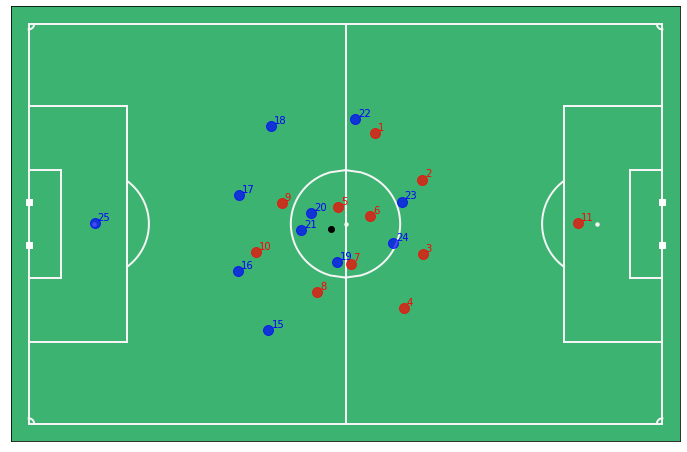

In [11]:
# plot average position of starting 11 players when home team is in possession

mviz.plot_frame(
    home_in_possession.describe()
    .loc["mean"]
    .drop(
        [x for x in tracking_home.columns for y in ["_12_", "_13_", "_14_"] if y in x]
    ),
    away_no_possession.describe()
    .loc["mean"]
    .drop(
        [x for x in tracking_away.columns for y in ["_26_", "_27_", "_28_"] if y in x]
    ),
    include_player_velocities=False,
    annotate=True,
)


(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

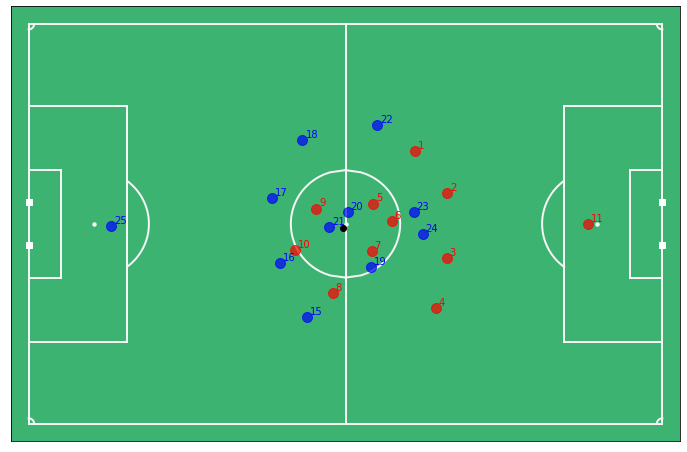

In [12]:
# plot average position of starting 11 players when away team is in possession
mviz.plot_frame(
    home_no_possession.describe()
    .loc["mean"]
    .drop(
        [x for x in tracking_home.columns for y in ["_12_", "_13_", "_14_"] if y in x]
    ),
    away_in_possession.describe()
    .loc["mean"]
    .drop(
        [x for x in tracking_away.columns for y in ["_26_", "_27_", "_28_"] if y in x]
    ),
    include_player_velocities=False,
    annotate=True,
)


Unfortunately, there does not seem to be a big difference in formation on and off the ball. The positions of the team on the ball are moved slightly forward relative to their positions off the ball, but we do not see a 4-3-3 suddenly changing to a 4-4-2 in defense or anything like that.